In [1]:
import torch
import torch.nn as nn
import torch.nn.functional as F
from torch.utils.data import DataLoader, Dataset

import numpy as np
import pandas as pd
import seaborn as sns

import matplotlib as mpl
import matplotlib.pyplot as plt
import matplotlib_inline.backend_inline

from sklearn.metrics import mean_squared_error, mean_squared_log_error

In [2]:
matplotlib_inline.backend_inline.set_matplotlib_formats("png2x")
mpl.style.use("default")
mpl.rcParams.update({"figure.constrained_layout.use": True})

sns.set_context("paper") 
sns.set_palette("Set2") 
sns.set_style("whitegrid") 

plt.rc("font", family = "Malgun Gothic")
plt.rcParams["axes.unicode_minus"] = False

In [3]:
# data_prep 에서 train/test split한 pivot table

train_scaled = pd.read_csv("./train_scaled.csv",index_col=0)
test_scaled = pd.read_csv("./test_scaled.csv",index_col=0)

train = pd.read_csv("./train_orig.csv",index_col=0)
test = pd.read_csv("./test_orig.csv",index_col=0)

In [45]:
city_info = ['date_label','geo_label_city']
features_list = []

target_list = ['Cancer | All Cancer Deaths']

# 결측치가 너무 많아/불균형해 제외된 column
avoid_list = ['Substance Use | Teen Smoking',
 'Diabetes and Obesity | Teen Obesity',
 'Substance Use | Teen Alcohol',
 'Physical Activity | Teen Computer Time',
 'Physical Activity | Teen Physical Activity',
 'Substance Use | Teen Marijuana',
 'Physical Activity | Teen TV Time',
 'Dietary Quality | Teen Soda',
 'Mental Health | Electronic Bullying',
 'Mental Health | School Bullying',
 'Mental Health | Teen Mental Distress',
 'Mental Health | Teen Suicidal Ideation',
 'Physical Activity | Teen Physical Inactivity',
 'Respiratory Disease | Teen Asthma',
 'School Violence | Fighting in School',
 'School Violence | Weapons in School',
 'Birth Control | Teen Birth Control',
 'Dietary Quality | Teen Breakfast',
 'Physical Activity | Teen Physical Education',
 'Respiratory Infection | COVID-19 Deaths',
 'Respiratory Infection | COVID-19 Vaccination, Adults',
 'Respiratory Infection | COVID-19 Vaccination, Seniors',
 'Births | Prenatal Care',
 'Crime Incidents | Violent Crime',
 'Lead Poisoning | Child Lead Levels 10+ mcg/dL',
 'Lead Poisoning | Child Lead Levels 5+ mcg/dL',
 'Lead Poisoning | Child Lead Testing']

# 일부 target 따라 너무 비슷한 값(ex) All Cancer를 예측할 때 세분화된 Cancer 사망자)
targetspecific_list = ['Cancer | Breast Cancer Deaths', 'Cancer | Colorectal Cancer Deaths','Cancer | Lung Cancer Deaths','Cancer | Prostate Cancer Deaths', 'Deaths | Deaths from All Causes']

# 두가지를 합쳐서 제외해야할 항목 결정
avoid_list += targetspecific_list

x_train = train_scaled.loc[:,~(train_scaled.columns.isin(avoid_list) | train_scaled.columns.isin(target_list) | train_scaled.columns.isin(city_info))]#features_list]
y_train = train[target_list]

x_test = test_scaled.loc[:,~(test_scaled.columns.isin(avoid_list) | test_scaled.columns.isin(target_list) | test_scaled.columns.isin(city_info))]#features_list]
y_test = test[target_list]

In [31]:
#heuristic하게 고른 항목들로만 하면 얼마나 나을까?

heuristic_list = ["Cancer | Breast Cancer Deaths",
"Cancer | Prostate Cancer Deaths",
"Physical Activity | Adult Physical Inactivity",
"Diabetes and Obesity | Diabetes",
"Diabetes and Obesity | Teen Obesity",
"Diabetes and Obesity | Adult Obesity",
"Dietary Quality | Teen Soda",
"Population | Seniors",
"Health Insurance | Uninsured, All Ages",
"Births | Low Birthweight",
"Births | Prenatal Care",
"Births | Preterm Births",
"Births | Teen Births",
"Income | Poverty in All Ages"]

x_train = x_train = train_scaled.loc[:,train_scaled.columns.isin(heuristic_list) & ~(train_scaled.columns.isin(avoid_list))]#features_list]
y_train = train[target_list]

x_test = test_scaled.loc[:,test_scaled.columns.isin(heuristic_list) & ~(test_scaled.columns.isin(avoid_list))]#features_list]
y_test = test[target_list]

In [46]:
class CityData(Dataset):
    def __init__(self, x_data, y_data):
        self.x_data = torch.Tensor(x_data.values)
        self.y_data = torch.Tensor(y_data.values)
    
    def __getitem__(self, index):
        return self.x_data[index], self.y_data[index]

    def __len__(self):
        return len(self.y_data)

ValueError: keyword grid_b is not recognized; valid keywords are ['size', 'width', 'color', 'tickdir', 'pad', 'labelsize', 'labelcolor', 'labelfontfamily', 'zorder', 'gridOn', 'tick1On', 'tick2On', 'label1On', 'label2On', 'length', 'direction', 'left', 'bottom', 'right', 'top', 'labelleft', 'labelbottom', 'labelright', 'labeltop', 'labelrotation', 'grid_agg_filter', 'grid_alpha', 'grid_animated', 'grid_antialiased', 'grid_clip_box', 'grid_clip_on', 'grid_clip_path', 'grid_color', 'grid_dash_capstyle', 'grid_dash_joinstyle', 'grid_dashes', 'grid_data', 'grid_drawstyle', 'grid_figure', 'grid_fillstyle', 'grid_gapcolor', 'grid_gid', 'grid_in_layout', 'grid_label', 'grid_linestyle', 'grid_linewidth', 'grid_marker', 'grid_markeredgecolor', 'grid_markeredgewidth', 'grid_markerfacecolor', 'grid_markerfacecoloralt', 'grid_markersize', 'grid_markevery', 'grid_mouseover', 'grid_path_effects', 'grid_picker', 'grid_pickradius', 'grid_rasterized', 'grid_sketch_params', 'grid_snap', 'grid_solid_capstyle', 'grid_solid_joinstyle', 'grid_transform', 'grid_url', 'grid_visible', 'grid_xdata', 'grid_ydata', 'grid_zorder', 'grid_aa', 'grid_c', 'grid_ds', 'grid_ls', 'grid_lw', 'grid_mec', 'grid_mew', 'grid_mfc', 'grid_mfcalt', 'grid_ms']

t:\miniconda3\envs\wassup_pr1\lib\site-packages\IPython\core\events.py:82: UserWarning: There are no gridspecs with layoutgrids. Possibly did not call parent GridSpec with the "figure" keyword
  func(*args, **kwargs)
t:\miniconda3\envs\wassup_pr1\lib\site-packages\IPython\core\pylabtools.py:170: UserWarning: There are no gridspecs with layoutgrids. Possibly did not call parent GridSpec with the "figure" keyword
  fig.canvas.print_figure(bytes_io, **kw)


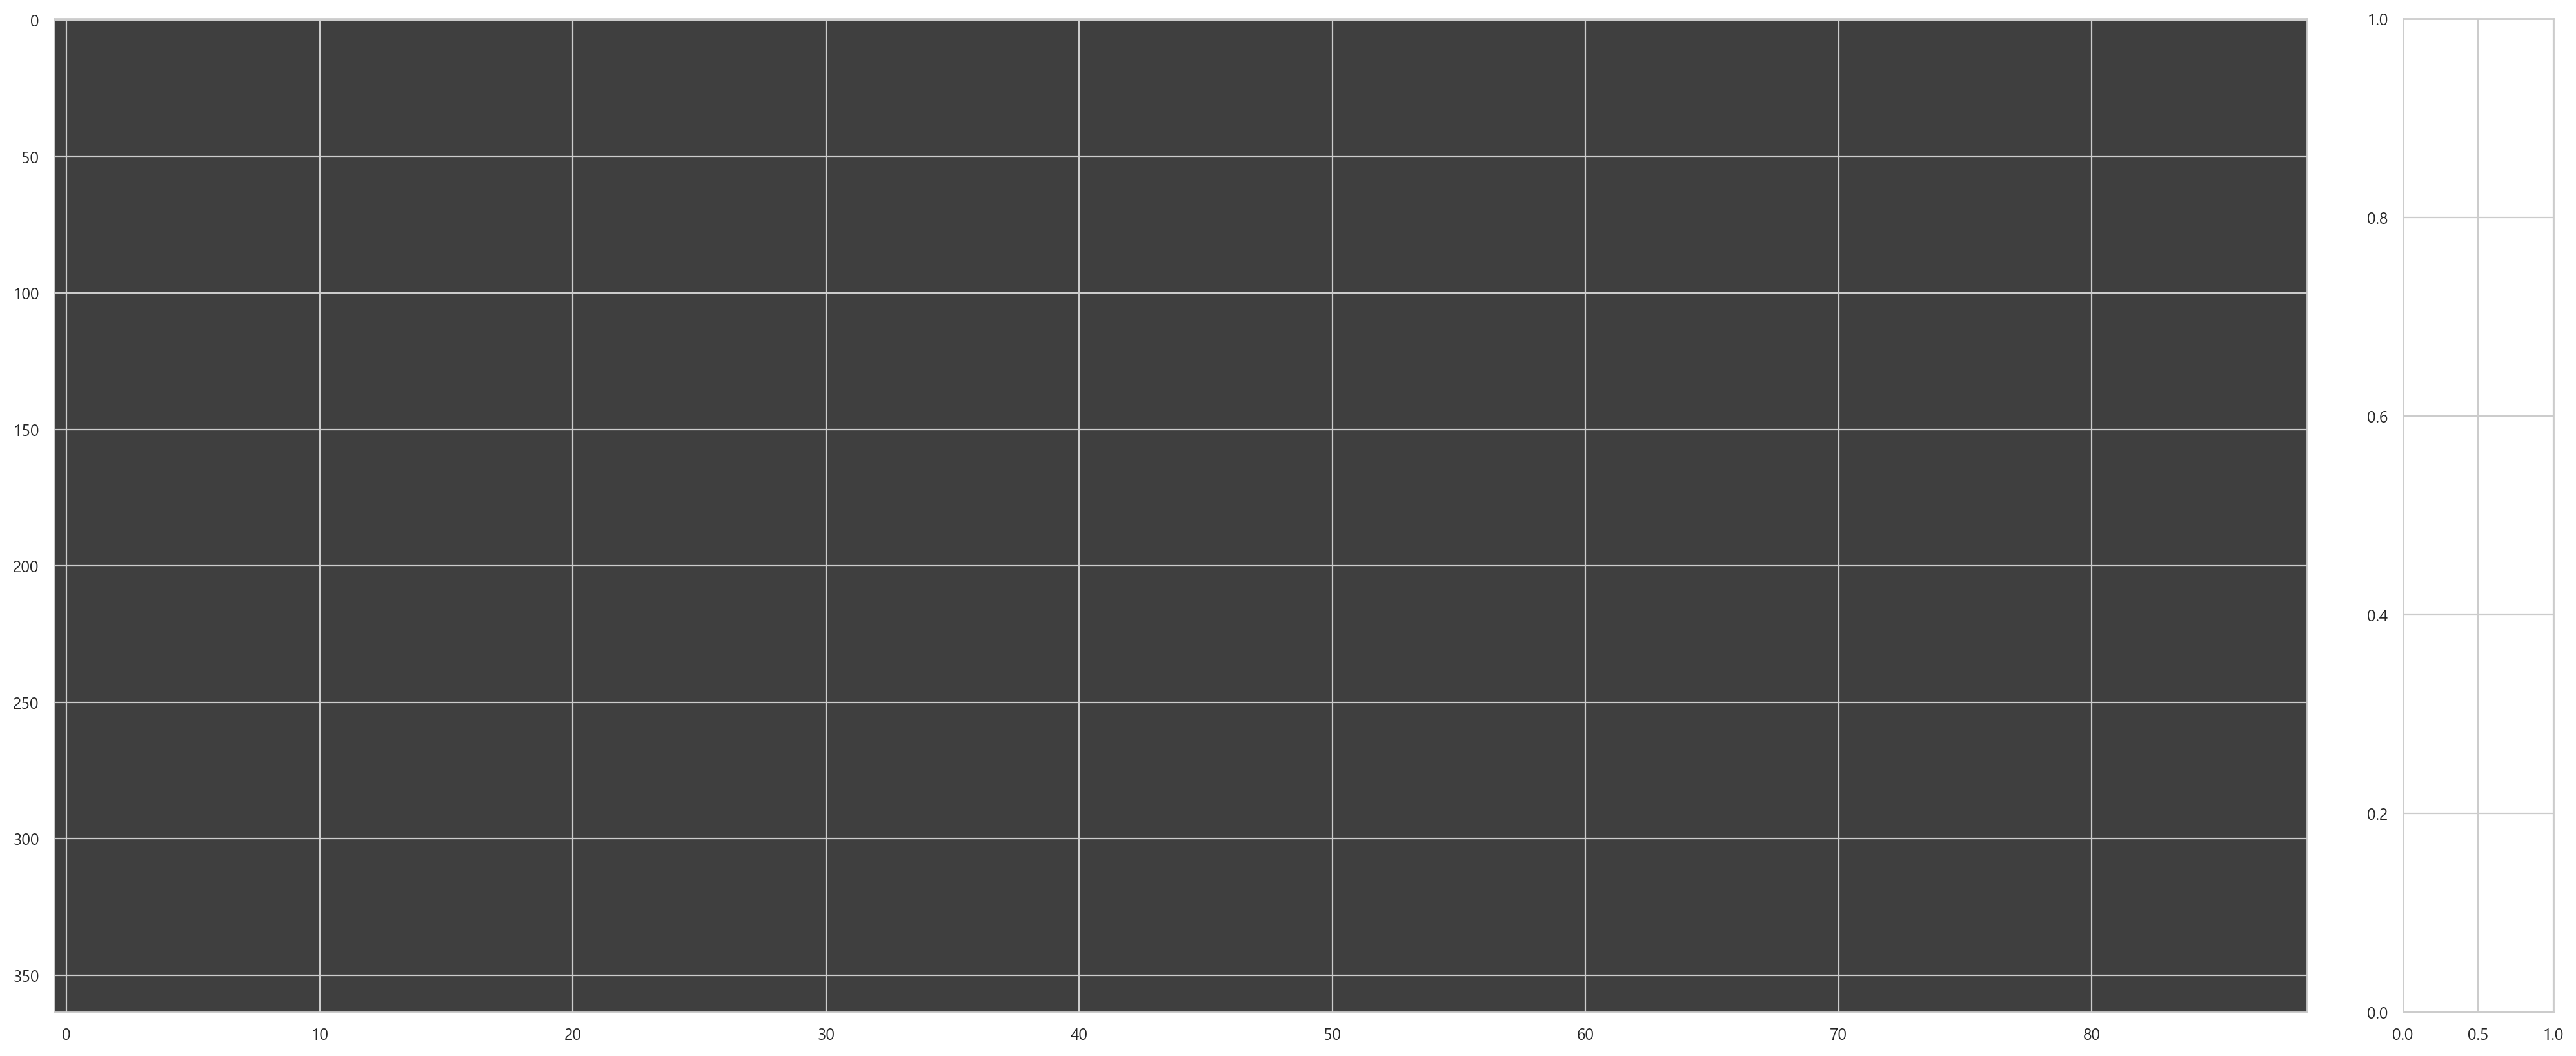

In [47]:
import missingno as msno

x_train = x_train.apply(lambda x: x.fillna(x.median()),axis=0)

x_test = x_test.apply(lambda x: x.fillna(x.median()),axis=0)

msno.matrix(x_train)

In [48]:
train_dataset = CityData(x_train, y_train)
train_loader = DataLoader(train_dataset, batch_size=32, shuffle=True)

test_dataset = CityData(x_test, y_test)
test_loader = DataLoader(test_dataset, batch_size=32, shuffle=False)

In [54]:
class MLPRegressor(nn.Module):
    def __init__(self):
        super().__init__()
        self.fc1 = nn.Linear(89,50)
        self.fc2 = nn.Linear(50,30)
        self.fc3 = nn.Linear(30,10)
        self.fc4 = nn.Linear(10,1)
        self.relu = nn.ReLU()
        self.dropout = nn.Dropout(0.2)
        self.sigmoid = nn.Sigmoid()
    
    def forward(self, x):
        # print(x)
        # x = self.fc1(x)
        # print(x)
        # x = self.sigmoid(x)
        # print(x)
        x = self.dropout(self.relu(self.fc1(x)))
        x = self.dropout(self.relu(self.fc2(x)))
        x = self.dropout(self.relu(self.fc3(x)))
        x = self.sigmoid(self.fc4(x))

        return x


In [55]:
model = MLPRegressor()
criterion = nn.MSELoss()

optimizer = torch.optim.Adam(model.parameters(), lr = 1e-5)
# optimizer = torch.optim.SGD(model.parameters(), lr = 1e-3, weight_decay  = 0.9)

input_shape = len(x_train.columns)
model.fc1 = nn.Linear(input_shape,50)

In [168]:
# !pip install livelossplot
# !conda install tqdm -y

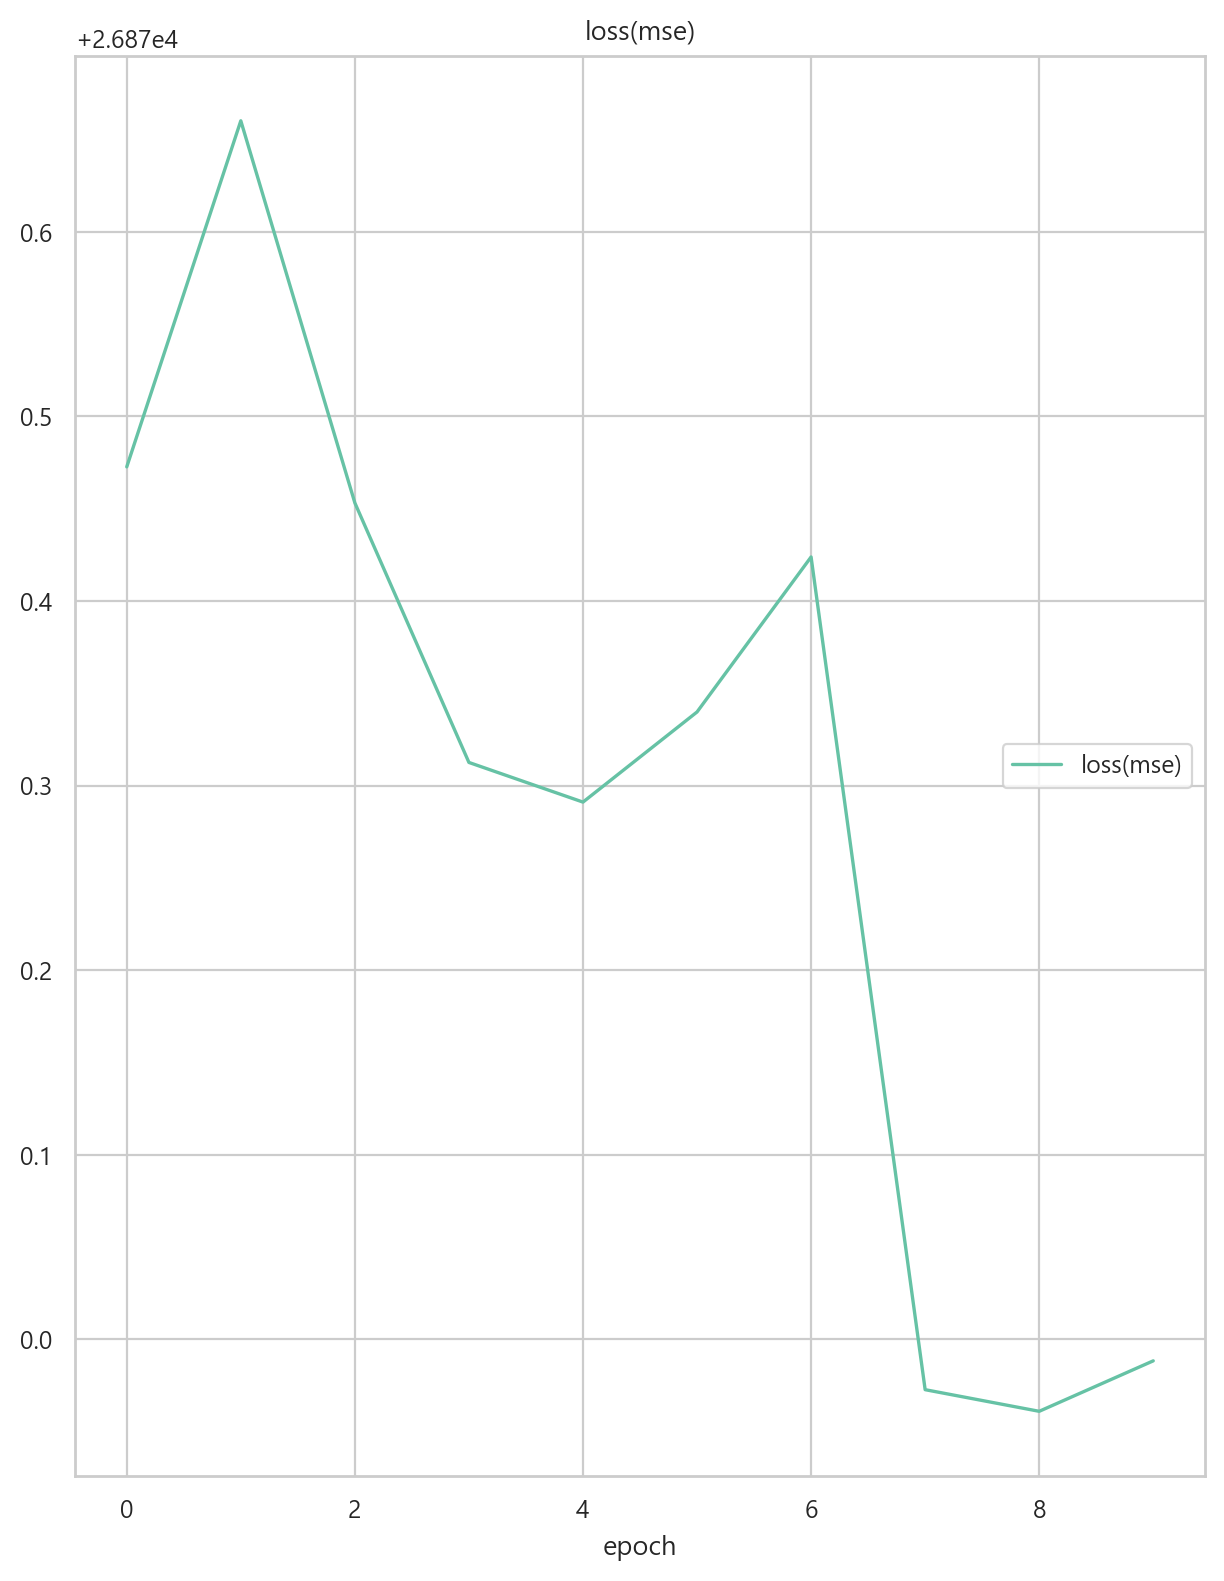

100%|██████████| 10/10 [00:05<00:00,  1.81it/s]


In [56]:
from livelossplot.outputs import MatplotlibPlot
from livelossplot import PlotLosses
from tqdm import tqdm, trange


train_loss = list()
n_epoch = 10

answer = torch.tensor([])
prediction = torch.tensor([])

plotlosses = PlotLosses(outputs=[MatplotlibPlot(figpath ="lossplot_mlp.png")])

model.train()
for epoch in trange(n_epoch):
    answer = torch.tensor([])
    prediction = torch.tensor([])
    for idx, data in enumerate(train_loader):
        x, y = data

        optimizer.zero_grad()
        yhat = model(x)

        loss = criterion(yhat, y)
        loss.backward()
        optimizer.step()


        prediction = torch.cat((prediction,yhat),0)
        answer = torch.cat((answer,y),0)
    
    prediction = prediction
    answer = answer

    plotlosses.update({
        'loss(mse)': F.mse_loss(prediction,answer).detach().numpy()
    })
    plotlosses.send()


In [52]:
prediction[0].shape, answer[0].shape

(torch.Size([1]), torch.Size([1]))

In [57]:
answer = torch.tensor([])
prediction = torch.tensor([])
with torch.no_grad():
    for idx, data in enumerate(test_loader):
        x, y = data
        # print(x)
        yhat = model(x)

        prediction = torch.cat((prediction,yhat),0)
        answer = torch.cat((answer,y),0)
prediction = prediction.detach().numpy()
answer = answer.numpy()
test_mse = mean_squared_error(prediction, answer)
test_rmse = np.sqrt(test_mse)

print(test_mse)
print(test_rmse)

26012.242
161.28311


In [38]:
prediction

array([[       nan],
       [       nan],
       [       nan],
       [       nan],
       [       nan],
       [       nan],
       [       nan],
       [       nan],
       [       nan],
       [       nan],
       [       nan],
       [       nan],
       [       nan],
       [       nan],
       [       nan],
       [       nan],
       [       nan],
       [       nan],
       [       nan],
       [       nan],
       [       nan],
       [       nan],
       [       nan],
       [       nan],
       [       nan],
       [       nan],
       [       nan],
       [       nan],
       [       nan],
       [       nan],
       [       nan],
       [       nan],
       [       nan],
       [       nan],
       [       nan],
       [       nan],
       [       nan],
       [       nan],
       [       nan],
       [       nan],
       [       nan],
       [       nan],
       [0.4146602 ],
       [0.39922726],
       [0.39246023],
       [0.44085386],
       [0.37154138],
       [0.415

In [17]:
np.argwhere(np.isnan(prediction))

array([[ 0,  0],
       [ 1,  0],
       [ 2,  0],
       [ 3,  0],
       [ 4,  0],
       [ 5,  0],
       [ 6,  0],
       [ 7,  0],
       [ 8,  0],
       [ 9,  0],
       [10,  0],
       [11,  0],
       [12,  0],
       [13,  0],
       [14,  0],
       [15,  0],
       [16,  0],
       [17,  0],
       [18,  0],
       [19,  0],
       [20,  0],
       [21,  0],
       [22,  0],
       [23,  0],
       [24,  0],
       [25,  0],
       [26,  0],
       [27,  0],
       [28,  0],
       [29,  0],
       [30,  0],
       [31,  0],
       [32,  0],
       [33,  0],
       [34,  0],
       [35,  0],
       [36,  0],
       [37,  0],
       [38,  0],
       [39,  0],
       [40,  0],
       [41,  0]], dtype=int64)

In [172]:
answer

array([[139.75826 ],
       [214.27632 ],
       [157.083   ],
       [161.44904 ],
       [170.52222 ],
       [158.09294 ],
       [207.21988 ],
       [142.01047 ],
       [216.50577 ],
       [158.91376 ],
       [162.80742 ],
       [168.20001 ],
       [157.02843 ],
       [210.01573 ],
       [143.01027 ],
       [214.07655 ],
       [159.05331 ],
       [155.8867  ],
       [165.59222 ],
       [153.13121 ],
       [212.19945 ],
       [142.39763 ],
       [209.84665 ],
       [156.15747 ],
       [170.77931 ],
       [164.3887  ],
       [149.38368 ],
       [211.0215  ],
       [138.09607 ],
       [201.00908 ],
       [153.71515 ],
       [168.58537 ],
       [161.92957 ],
       [146.17964 ],
       [202.25792 ],
       [132.28104 ],
       [198.9189  ],
       [152.04617 ],
       [162.67932 ],
       [158.7351  ],
       [143.68494 ],
       [193.75403 ],
       [126.63023 ],
       [194.22392 ],
       [153.3173  ],
       [154.90721 ],
       [156.24133 ],
       [140.9

In [176]:
prediction

array([[       nan],
       [       nan],
       [       nan],
       [       nan],
       [       nan],
       [       nan],
       [       nan],
       [       nan],
       [       nan],
       [       nan],
       [       nan],
       [       nan],
       [       nan],
       [       nan],
       [       nan],
       [       nan],
       [       nan],
       [       nan],
       [       nan],
       [       nan],
       [       nan],
       [       nan],
       [       nan],
       [       nan],
       [       nan],
       [       nan],
       [       nan],
       [       nan],
       [       nan],
       [       nan],
       [       nan],
       [       nan],
       [       nan],
       [       nan],
       [       nan],
       [       nan],
       [       nan],
       [       nan],
       [       nan],
       [       nan],
       [       nan],
       [       nan],
       [0.99901295],
       [0.99912006],
       [0.9983584 ],
       [0.99814665],
       [0.9982272 ],
       [0.997